# Data preprocessing

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np #scientific library
import scipy #scientific library
import scipy.io.wavfile
import sys, os #file reading, directory parsing routines
import matplotlib #to plot
import matplotlib.pyplot as plt

### Audio file reading 

(132299, 2)


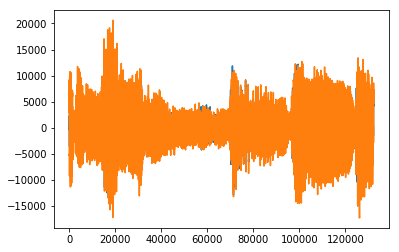

In [2]:
path_to_irmas = '/Users/mariusmiron/Desktop/pydata2017bcn/IRMAS-Sample/'

#read audio file
audio_file = '001__[vio][nod][cou_fol]2194__1.wav'
sampleRate, audioObj = scipy.io.wavfile.read(os.path.join(path_to_irmas,'Training','vio',audio_file)) 

print audioObj.shape
plt.plot(audioObj)
plt.show()

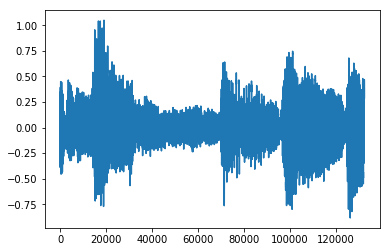

In [3]:
import util

audio, sampleRate, bitrate = util.readAudioScipy(os.path.join(path_to_irmas,'Training','vio',audio_file)) 

plt.plot(audio.sum(axis=1))
plt.show()

### Feature computation

In [4]:
import transform

spectrogram = transform.stft_norm(audio.sum(axis=1), window=np.hanning(1024), hopsize=512, nfft=1024, fs=float(sampleRate))

spectrogram.shape 


(261, 513)

In [5]:
print spectrogram[0,0]
mag = np.abs(spectrogram)
print mag[0,0]

mag = mag  / np.sqrt(1024) #normalization
mag.shape

(7.34953326163+0j)
7.34953326163


(261, 513)

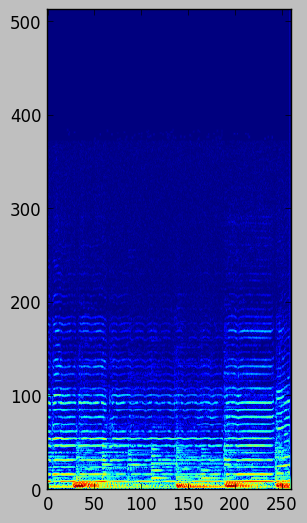

In [6]:
#print plt.style.available
plt.style.use('classic')
plt.imshow(np.log10(1+100*mag).T,interpolation='none', origin='lower')
plt.show()

In [7]:

mel_basis = transform.mel(sampleRate, n_fft=1024, n_mels=48, fmin=0, fmax=float(sampleRate)/2, htk=False,norm=1)
mel_basis.shape      

(48, 513)

In [8]:
melspec = np.dot(mel_basis, mag.T)
melspec.shape

(48, 261)

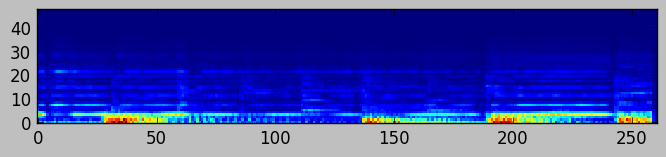

In [9]:
plt.imshow(np.log10(1+100*melspec),interpolation='none', origin='lower')
plt.show()

In [10]:
feature_dir_train = os.path.join(path_to_irmas,'features','Training')
if not os.path.exists(feature_dir_train):
    os.makedirs(feature_dir_train)

#save the features to file
melspec.tofile(os.path.join(feature_dir_train,audio_file.replace('.wav','.data')))
#load the features from file
melspecin = np.fromfile(os.path.join(feature_dir_train,audio_file.replace('.wav','.data')))
print melspecin.shape
#we need to save the shape
melspecin = melspecin.reshape(melspec.shape)

(12528,)


In [11]:
from transform import transformMEL
tr = transformMEL(bins=48, frameSize=1024, hopSize=512)

d=os.path.join(path_to_irmas,'Training')
instruments = sorted(filter(lambda x: os.path.isdir(os.path.join(d, x)), os.listdir(d)))

for count,inst in enumerate(instruments):
    for f in os.listdir(os.path.join(d,inst)):
        if os.path.isfile(os.path.join(d,inst, f)) and f.endswith('.wav'):
            audio, sampleRate, bitrate = util.readAudioScipy(os.path.join(d,inst,f)) 
            tr.compute_transform(audio.sum(axis=1),out_path=os.path.join(feature_dir_train,f.replace('.wav','.data')),suffix='_mel_',sampleRate=sampleRate)
            util.saveTensor(np.array([count]),out_path=os.path.join(feature_dir_train,f.replace('.wav','.data')),suffix='_label_')

### Batch generation

In [12]:
#build a list with all the .data files in the training dataset 
feature_dir_train = os.path.join(path_to_irmas,'features','Training')
suffix_in='_mel_'
suffix_out='_label_'
file_list = [f for f in os.listdir(feature_dir_train) 
            if f.endswith(suffix_in+'.data') and 
            os.path.isfile(os.path.join(feature_dir_train,f.replace(suffix_in,suffix_out))) ]
print file_list 

['001__[vio][nod][cou_fol]2194__1_mel_.data', '118__[sax][nod][jaz_blu]1702__3_mel_.data', '134__[vio][nod][cla]2156__3_mel_.data']


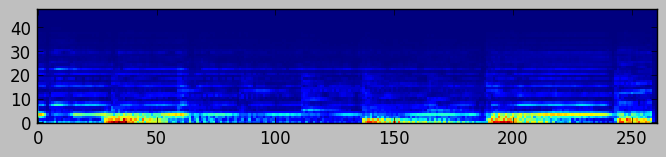

(261, 48)


In [13]:
#let's load the first file
melspec = util.loadTensor(out_path=os.path.join(feature_dir_train,file_list[0]))
plt.imshow(np.log10(1+100*melspec.T),interpolation='none', origin='lower')
plt.show()
print melspec.shape

In [14]:
#parameters to generate blocks of data from spectrograms
time_context=100 #time context modeled by the network
overlap = 25 #overlap to generate more blocks

noinstances = int(np.floor(melspec.shape[0]/float(time_context-overlap)))
print "number of instances: "+str(noinstances)

number of instances: 3


In [15]:
def getNumInstances(infile,time_context=100,overlap=25):
    """
    For a single .data file computes the number of examples of size \"time_context\" that can be created
    """
    shape = util.get_shape(os.path.join(infile.replace('.data','.shape')))
    length_file = shape[0]
    return np.maximum(1,int(np.floor(length_file/float(time_context-overlap))))
    
noinstances=getNumInstances(infile=os.path.join(feature_dir_train,file_list[0]),time_context=time_context,overlap=overlap)
print "number of instances: "+str(noinstances)

total_noinstances = np.cumsum(np.array([0]+[ getNumInstances(os.path.join(feature_dir_train,infile),time_context=100,overlap=25) for infile in file_list], dtype=int))
print "total number of instances: "+str(total_noinstances)

number of instances: 3
total number of instances: [0 3 6 9]


In [41]:
def getFeatureSize(infile):
    """
    For a single .data file return the number of feature, e.g. number of spectrogram bins
    """
    shape = util.get_shape(os.path.join(infile.replace('.data','.shape')))
    return shape[1]


floatX = np.float32 #array type for compatibility with the GPU 
feature_size = getFeatureSize(infile=os.path.join(feature_dir_train,file_list[0]))
print "feature size "+str(feature_size)
#features=np.zeros((total_noinstances[-1],time_context,feature_size),dtype=floatX)
#labels=np.zeros((total_noinstances[-1],time_context,feature_size),dtype=floatX)

feature size 48


In [35]:
import dataset
from dataset import MyDataset

db=MyDataset(feature_dir=feature_dir_train, batch_size=32, time_context=100, overlap=25, suffix_in='_mel_',suffix_out='_label_',floatX=np.float32)
print "total number of instances: "+str(db.total_points)
print "batch_size: "+str(db.batch_size)  
print "feature shape"+str(db.features.shape)
print "labels shape"+str(db.labels.shape)

total number of instances: 9
batch_size: 9
feature shape(9, 100, 48)
labels shape(9, 1)


In [37]:
#what do we return at each call
feat=db.features[db.iteration_step*db.batch_size:(db.iteration_step+1)*db.batch_size]
print feat.shape
feat=db.features[db.iteration_step*db.batch_size:(db.iteration_step+1)*db.batch_size,np.newaxis]
print feat.shape
lab=db.labels[db.iteration_step*db.batch_size:(db.iteration_step+1)*db.batch_size]
print lab.shape

(9, 100, 48)
(9, 1, 100, 48)
(9, 1)


(9, 1, 100, 48)


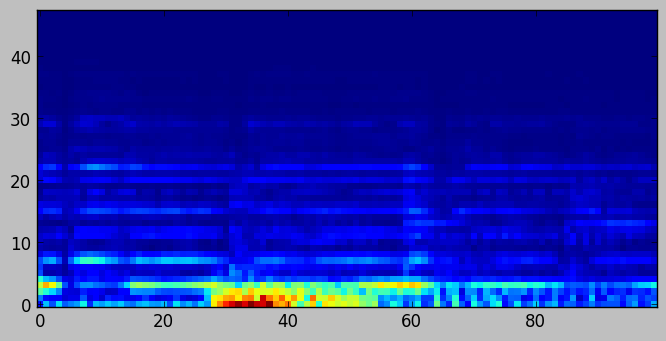

In [47]:
features,labels = db()
print features.shape
plt.imshow(np.log10(1+100*features[0,0,:,:].T),interpolation='none', origin='lower')
plt.show()